In [33]:
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
import scipy.stats as stats

import backtrader as bt

import warnings
import itertools
warnings.filterwarnings('ignore')

## Import Data and Format it Accordingly

In [2]:
asset_a = 'SANDUSDT'
asset_b = 'AXSUSDT'
ohlc = {'date': [], 'open': [], 'high': [], 'low': [], 'close': []}
ohlc_a = {'date': [], 'open': [], 'high': [], 'low': [], 'close': []}
ohlc_b = {'date': [], 'open': [], 'high': [], 'low': [], 'close': []}

data_a = pd.read_csv('./{}_1h.csv'.format(asset_a), index_col=0)
data_a.iloc[:,0] = pd.to_datetime(data_a.iloc[:,0], unit='ms')
data_b = pd.read_csv('./{}_1h.csv'.format(asset_b), index_col=0)
data_b.iloc[:,0] = pd.to_datetime(data_b.iloc[:,0], unit='ms')

ohlc_a['date'] = data_a['0']
ohlc_a['open'] = data_a['1']
ohlc_a['high'] = data_a['2']
ohlc_a['low'] = data_a['3']
ohlc_a['close'] = data_a['4']

ohlc_b['date'] = data_b['0']
ohlc_b['open'] = data_b['1']
ohlc_b['high'] = data_b['2']
ohlc_b['low'] = data_b['3']
ohlc_b['close'] = data_b['4']

ohlc_a = pd.DataFrame(ohlc_a)
ohlc_b = pd.DataFrame(ohlc_b)

# make data same size
length_A = len(ohlc_a)
length_B = len(ohlc_b)
if length_A > length_B:
    ohlc_a = ohlc_a[(length_A-length_B):]
elif length_B > length_A:
    ohlc_b = ohlc_b[(length_B-length_A):]
        
ohlc['date'] = list(ohlc_a['date'])
ohlc['Open'] = np.array(ohlc_a['open'])/np.array(ohlc_b['open'])
ohlc['High'] = np.array(ohlc_a['high'])/np.array(ohlc_b['high'])
ohlc['Low'] = np.array(ohlc_a['low'])/np.array(ohlc_b['low'])
ohlc['Close'] = np.array(ohlc_a['close'])/np.array(ohlc_b['close'])

In [3]:
# Import Data
assets = ['BTCUSDT', 'ETHUSDT', 'LUNAUSDT', 'SOLUSDT', 'FTMUSDT', 'GALAUSDT', 'NEARUSDT', 'AVAXUSDT', '1000SHIBUSDT', 'SANDUSDT', 'WAVESUSDT', 'ADAUSDT', 'XRPUSDT', 'RUNEUSDT', 'BNBUSDT', 'ATOMUSDT', 'MATICUSDT', 'DOTUSDT', 'MANAUSDT', 'LINKUSDT', 'KNCUSDT', 'AXSUSDT', 'DOGEUSDT', 'LTCUSDT', 'CRVUSDT', 'FILUSDT', 'ONEUSDT']
data = {}
prices = {}

for asset in assets:
    data[asset] = pd.read_csv('./{}_1h.csv'.format(asset), index_col=0)
    data[asset].iloc[:,0] = pd.to_datetime(data[asset].iloc[:,0], unit='ms')
    prices[asset] = pd.DataFrame({'date': data[asset].iloc[:,0], 'price': data[asset].iloc[:,3]})
    prices[asset]['price'] = prices[asset]['price'].apply(lambda x: math.log(x))

In [28]:
# Strategies
class LongShortRsi(bt.SignalStrategy):
    
    def __init__(self):
        self.rsi = bt.ind.RSI(self.data, period=14)
    
    def next(self):
        if self.rsi <= 30:
            self.buy()
        if self.rsi >= 70:
            self.sell()

In [57]:
class LongShortRsi2(bt.Strategy):
    # Define the parameters of the strategy
    params = (
        ('portfolio_expo', 0.98),  # Max 15% of the Portfolio per trade
        ('trade_risk', 0.02),  # Max 2% risk per trade (stop loss)
        ('atrdist', 2.0),  # ATR based Stop loss distance
        ('stake', 1.00),
        ('mtrade', False)
    )

    def notify_order(self, order):
        if order.status == order.Completed:
            pass

        if not order.alive():
            self.order = None  # indicate no order is pending

    # Initialize the elements which are needed for the strategy (indicators, etc...)
    def __init__(self):
        
        self.inLong = False
        self.inShort = False
        
        # Define the indicators
        
        self.rsi = bt.ind.RSI(self.data, period=14)

        if self.p.mtrade:
            self.tradeid = itertools.cycle([0, 1, 2])
        else:
            self.tradeid = itertools.cycle([0])


    def start(self):
        self.order = None  # sentinel to avoid operations on pending order

    def prenext(self):
        self.next()

    def next(self):

        # Get the Amount of cash in the Portfolio
        cash = self.broker.get_cash()

        if self.order:
            return  # pending order execution

        if not self.inLong and self.rsi <= 30.0:
        
            self.buy(size=cash*0.95)
            self.inLong = True
            self.inShort = False

        elif not self.inShort and self.rsi >= 70.0:
            
            self.sell(size=cash*0.95)
            self.inLong = False
            self.inShort = True
            
        

<IPython.core.display.Javascript object>


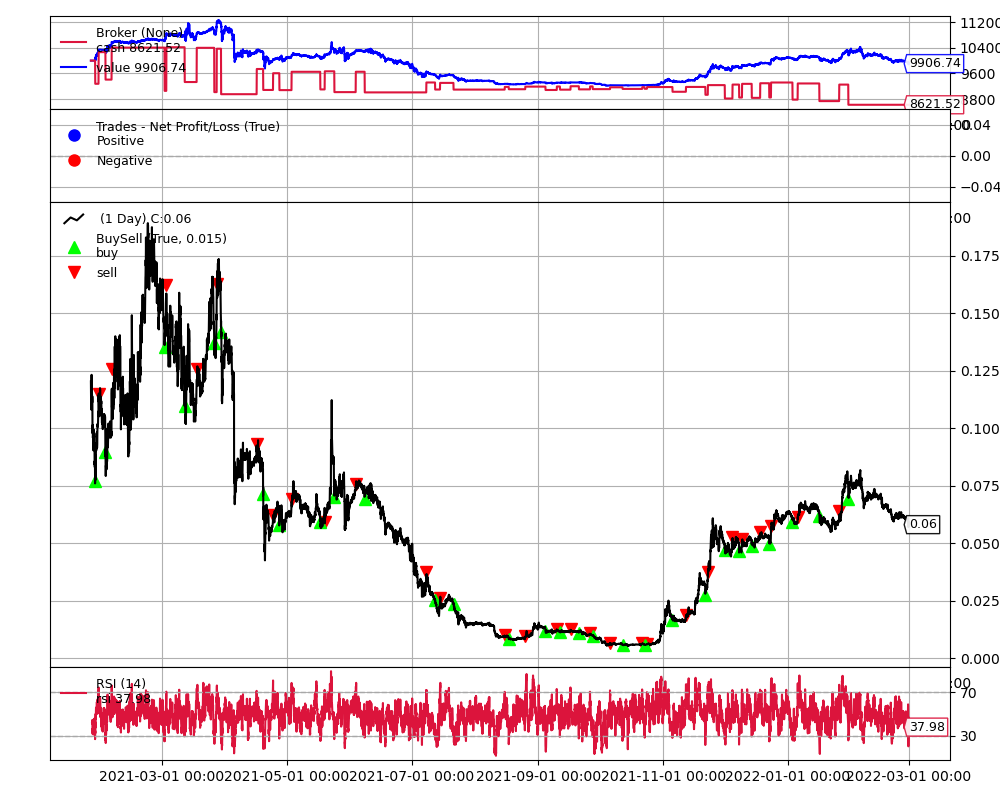

[[<Figure size 1000x800 with 4 Axes>]]

In [58]:

cerebro = bt.Cerebro()
cerebro.addstrategy(LongShortRsi2)

df = pd.DataFrame({'Open': ohlc['Open'], 'High': ohlc['High'], 'Low': ohlc['Low'], 'Close': ohlc['Close']})
df.index = ohlc['date']
feed = bt.feeds.PandasData(dataname=df)

cerebro.adddata(feed)

cerebro.run()
plt.rcParams['figure.figsize']=[10, 8]
plt.rcParams['figure.dpi']=100
cerebro.plot(volume=False, iplot=False)